In [2]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display, clear_output
from IPython import display as ipd

In [3]:
def readMeetingAudio(audioPath):
    meetingAudio_fs, meetingAudio = wavfile.read(audioPath)
    if not ((meetingAudio[:, 0] == meetingAudio[:, 1]).any() == False):
        meetingAudio = meetingAudio[:, 1]
    return meetingAudio_fs, meetingAudio

In [4]:
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a. strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [5]:
beepAudio_sr, beepAudio = wavfile.read('Files/beep.wav')

In [6]:
meetingAudioFiles = ['z.wav', 'zoom2.wav', 'P1.wav', 'P2.wav', 'P3.wav']
meetings = [readMeetingAudio('Files/'+f) for f in meetingAudioFiles]

In [7]:
meeting_sr, meeting = readMeetingAudio('Files/P3.wav')#meetings[-1]

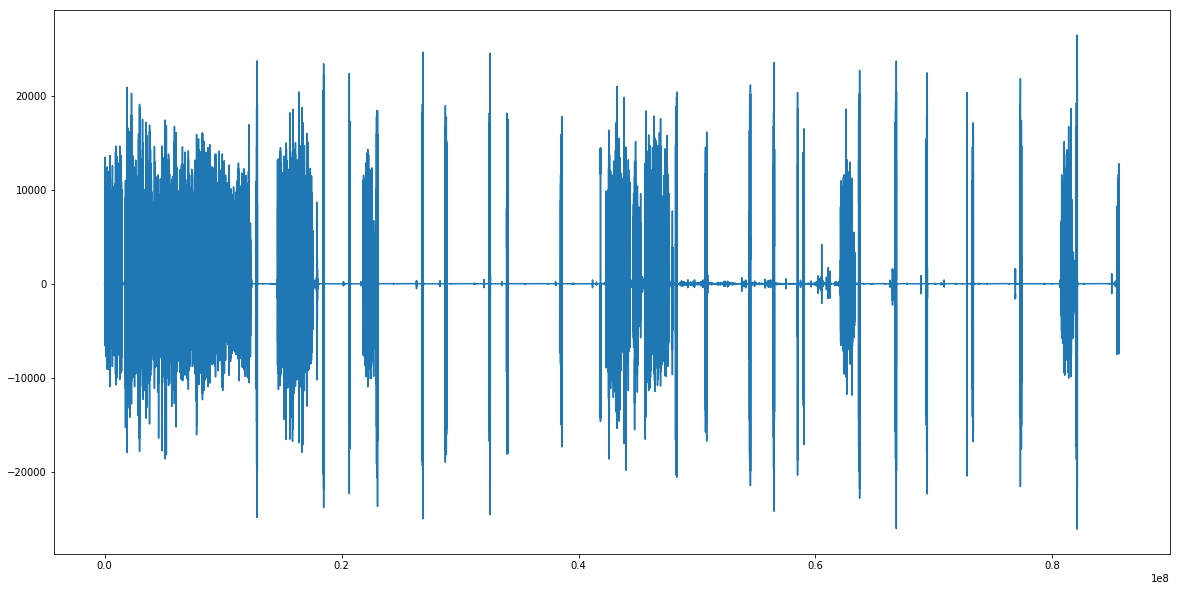

In [7]:
fig =plt.figure(figsize=(20,10))
plt.plot(meeting)

In [8]:
def getNoiseIntervals(audio, fs, threshold = 3000):
    audio = abs(audio)
    loudIndices = np.where(audio > threshold)[0]
    loudStartIndex = loudIndices[0]
    lastLoudIndex = loudIndices[0]
    noiseIntervals = []
    for i in range(len(loudIndices[1:-1])):
        if lastLoudIndex + fs >= loudIndices[i]:
            if loudIndices[i] + fs < loudIndices[i+1]:
                noiseIntervals.append((loudStartIndex, loudIndices[i]))
        else:
            loudStartIndex = loudIndices[i]
        lastLoudIndex = loudIndices[i]
    if len(loudIndices) > 0:
        if len(noiseIntervals) == 0: 
            noiseIntervals.append((loudStartIndex, loudIndices[-1]))
        elif noiseIntervals[-1] != (loudStartIndex, loudIndices[i]):
            noiseIntervals.append((loudStartIndex, loudIndices[i]))
    return noiseIntervals

In [9]:
noiseIntervals = getNoiseIntervals(meeting, meeting_sr/25, threshold = 2000)
print(len(noiseIntervals))

200


In [10]:
loudIndices = np.zeros_like(meeting)
for i, j in noiseIntervals:
    loudIndices[i] = 3000
    loudIndices[j] = 3000

In [11]:
t = lambda s: '%02d:%02d' % (int(s/60), int(s % 60))
it = lambda m, s: int((m*60+s)*meeting_sr)

In [12]:
def findTrueCorrelation(audio, fltr, distance = 50):
    corrs = []
    if len(audio) <= distance or len(audio) <= len(fltr)/5:
        return 0
    elif len(audio) > len(fltr):
        windows = rolling_window(audio, len(fltr))
        increment = 1 if len(windows) < 10 else int(len(windows)/10)
        windows = [windows[i] for i in range(0, len(windows), increment)]
        corrs = [np.corrcoef(row, fltr)[0, 1] for row in windows]
    else:
        for i in range(distance):
            corrs.append(np.corrcoef(audio[i:], fltr[:len(audio)-i])[0, 1])
    if not corrs: return 0
    return max(corrs)

In [13]:
beepIntervals = []
for beginIndex, endIndex in noiseIntervals:
    corrs = findTrueCorrelation(meeting[beginIndex:endIndex], beepAudio, distance = 50)
    if corrs > 0.2:
        print('%s - %.2f, %.2f'%(t(beginIndex/meeting_sr), (endIndex-beginIndex)/meeting_sr, corrs))
        beepIntervals.append((beginIndex, endIndex))
#     else:
#         print('%s - %.2f'%(t(beginIndex/meeting_sr), (endIndex-beginIndex)/meeting_sr))

00:19 - 0.72, 0.92
01:17 - 0.72, 0.95
01:29 - 0.72, 0.90
02:02 - 0.72, 0.92
02:11 - 0.14, 0.30
02:14 - 0.73, 0.93
03:26 - 0.72, 0.96
03:38 - 0.72, 0.96
04:00 - 0.72, 0.95
04:10 - 0.15, 0.34
04:12 - 0.72, 0.96
05:18 - 0.72, 0.96
05:30 - 0.72, 0.97
06:18 - 0.72, 0.96
06:30 - 0.72, 0.97
07:14 - 0.72, 0.97
07:26 - 0.72, 0.94
08:40 - 0.72, 0.96
08:52 - 0.72, 0.96
10:04 - 0.70, 0.98
11:02 - 0.72, 0.97
12:33 - 0.73, 0.95
12:45 - 0.72, 0.35
14:01 - 0.72, 0.97
14:14 - 0.72, 0.97
15:22 - 0.72, 0.97
15:34 - 0.72, 0.97
16:20 - 0.72, 0.91
16:32 - 0.73, 0.85
19:19 - 0.72, 0.97
19:31 - 0.72, 0.96
20:45 - 0.72, 0.96


In [15]:
len(beepIntervals)

32

In [16]:
beepIndices = np.zeros_like(meeting)
for i, j in beepIntervals:
    beepIndices[i] = 3000
    beepIndices[j] = 3000 

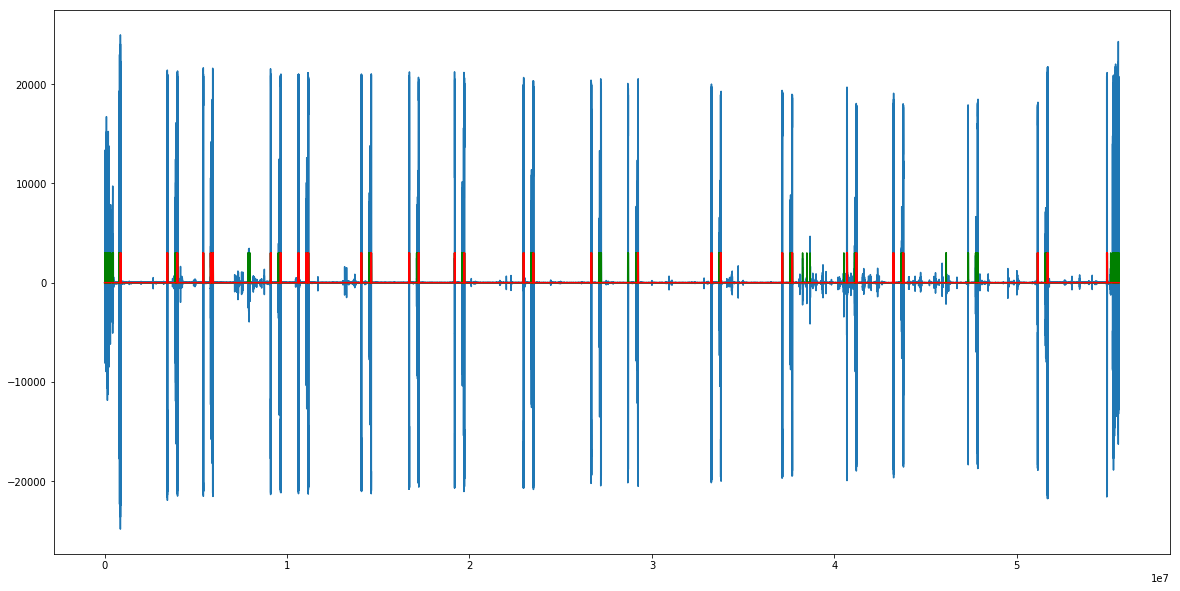

In [17]:
fig = plt.figure(figsize=(20,10))
plt.plot(meeting)
plt.plot(loudIndices, color='green')
plt.plot(beepIndices, color='red')

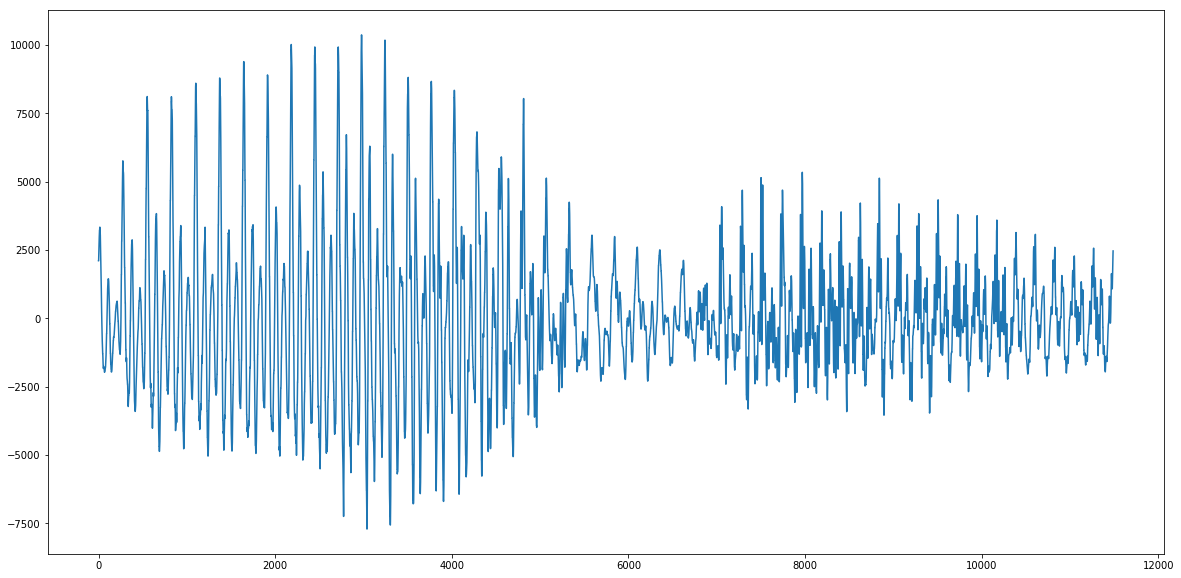

In [17]:
fig =plt.figure(figsize=(20,10))
beginIndex, endIndex = noiseIntervals[-1]
plt.plot(meeting[beginIndex:endIndex])

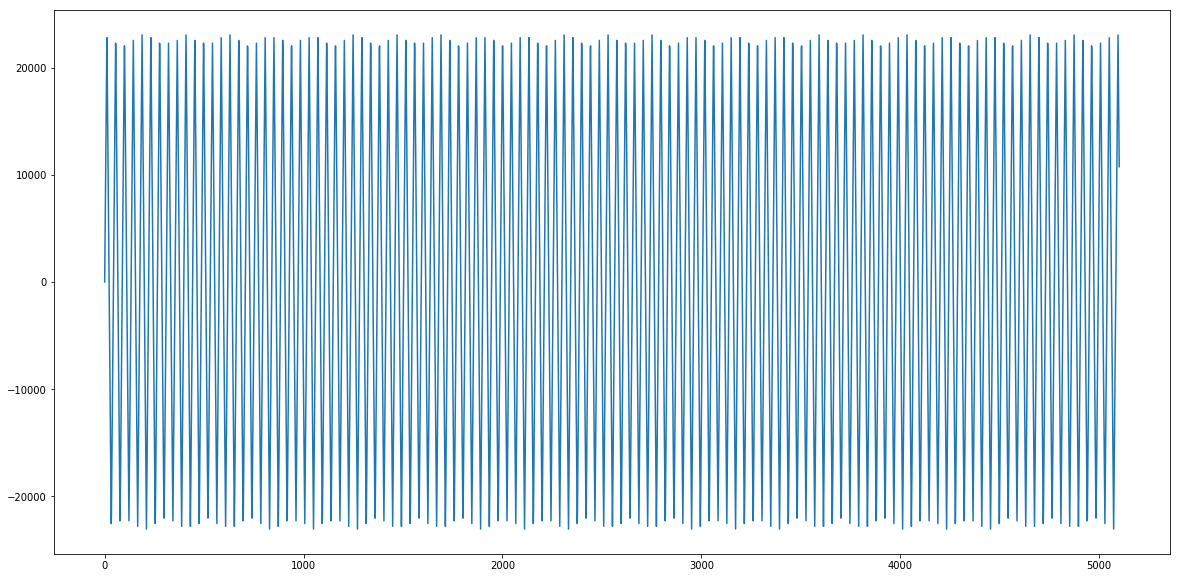

In [81]:
fig =plt.figure(figsize=(20,10))
plt.plot(beepAudio[:endIndex-beginIndex])